#### Loading Libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from itertools import product

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import spearmanr
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu

import logging
from ray import tune
from IPython.display import display

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MAE,RMSE,MQLoss

from utilsforecast.plotting import plot_series
from utilsforecast.losses import mse, mae, rmse
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae, rmse

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation


#### Loading Data

In [81]:
train_set = pd.read_csv(r"C:\Users\Armando\Desktop\data\train.csv")
stores_set = pd.read_csv(r"C:\Users\Armando\Desktop\data\stores.csv")
oil_set = pd.read_csv(r"C:\Users\Armando\Desktop\data\oil.csv")
holiday_set = pd.read_csv(r"C:\Users\Armando\Desktop\data\holidays_events.csv")
transactions_set = pd.read_csv(r"C:\Users\Armando\Desktop\data\transactions.csv")

#### Display Options

In [82]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
#αν θελω reset
#pd.reset_option('display.max_columns')

#### Data Preparation

In [83]:
#ελεγχος για διπλοτυπα
print(train_set.duplicated().sum(),
      stores_set.duplicated().sum(),
      oil_set.duplicated().sum(),
      holiday_set.duplicated().sum(),
      transactions_set.duplicated().sum()
      )

0 0 0 0 0


In [84]:
train_set.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [85]:
stores_set.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [86]:
oil_set.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [87]:
holiday_set.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [88]:
transactions_set.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [89]:
#Merges
df = pd.merge(train_set,stores_set,on='store_nbr',how='left')
df = pd.merge(df,oil_set,on ='date',how='left')
df = pd.merge(df,transactions_set,on=['date','store_nbr'],how='left')

In [90]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN


In [91]:
print(
    f"The dataset contains {df.shape[0]} samples and "
    f"{df.shape[1]} features"
)

The dataset contains 3000888 samples and 12 features


In [92]:
#Κοιταω για Nas
df.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
dcoilwtico      928422
transactions    245784
dtype: int64

In [93]:
sales_zero = df[df['sales'] == 0]

In [94]:
sales_zero.isna().sum() # 291028 - 245869 = 45159

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
dcoilwtico      291028
transactions    242536
dtype: int64

In [95]:
df.loc[df['sales']==0,'transactions']=0

In [96]:
df.loc[df['sales']==0,'transactions']=0
del sales_zero
df['transactions'] = df.groupby('store_nbr')['transactions'].ffill()

In [97]:
#Απο αυτο βλεπουμε οτι δεν εχουμε την τιμη του πετρελαιου για ολες τις ημερομινιες
print(len(train_set['date'].unique()),len(oil_set['date'].unique()))

1684 1218


In [98]:
df['date']= pd.to_datetime(df['date'])
df['day']= df['date'].dt.day_name()
working_days = df[df['date'].dt.dayofweek < 5]

In [99]:
print(df.loc[df['day'] == 'Saturday', 'dcoilwtico'].isna().sum() +
      df.loc[df['day'] == 'Sunday', 'dcoilwtico'].isna().sum() 
      )

857142


In [100]:
#Βρισκω το Σ/Κ με τιμες Na στο πετρελαιο
weekend_mask = df['day'].isin(['Saturday', 'Sunday']) & df['dcoilwtico'].isna()
df['price_filled'] = df['dcoilwtico']
df['price_filled'] = df['price_filled'].where(df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))
df['price_filled'] = df['price_filled'].ffill()
df.loc[weekend_mask, 'dcoilwtico'] = df.loc[weekend_mask, 'price_filled']
df.drop(columns=['price_filled'], inplace=True)

In [101]:
df['dcoilwtico'] = df['dcoilwtico'].interpolate(method='linear')
df['dcoilwtico'] = df['dcoilwtico'].bfill()
df['transactions'] = df['transactions'].fillna(0)

In [102]:
#Για τις υπολοιπες τιμες του πετρελαιου που δεν εχουμε κανουμε imputation
#df['dcoilwtico'] = df['dcoilwtico'].ffill()

In [103]:
holiday_set.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
 12  day           object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 297.6+ MB


In [105]:
transactions_set.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [106]:
df.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type            0
cluster         0
dcoilwtico      0
transactions    0
day             0
dtype: int64

In [107]:
df.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type            0
cluster         0
dcoilwtico      0
transactions    0
day             0
dtype: int64

In [108]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday


#### Exploratory Data Analysis

In [109]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday


In [110]:
print(
    f"The dataset contains {df.shape[0]} samples and "
    f"{df.shape[1]} features"
)

The dataset contains 3000888 samples and 13 features


In [111]:
len(df['store_nbr'].unique())

54

In [112]:
df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [113]:
len(df['family'].unique())

33

In [114]:
df['city'].unique()

array(['Quito', 'Cayambe', 'Latacunga', 'Riobamba', 'Ibarra',
       'Santo Domingo', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil',
       'Salinas', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad',
       'Cuenca', 'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [115]:
len(df['city'].unique())

22

In [116]:
df['state'].unique()

array(['Pichincha', 'Cotopaxi', 'Chimborazo', 'Imbabura',
       'Santo Domingo de los Tsachilas', 'Bolivar', 'Pastaza',
       'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja',
       'El Oro', 'Esmeraldas', 'Manabi'], dtype=object)

In [117]:
len(df['state'].unique())

16

In [118]:
df['type'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [119]:
sorted(df['cluster'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [120]:
df['day'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [121]:
df[['sales','onpromotion','transactions','dcoilwtico']].describe()

,sales,onpromotion,transactions,dcoilwtico
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,3.577757e+02,2.602770e+00,1.196714e+03,6.791966e+01
std,1.101998e+03,1.221888e+01,1.148411e+03,2.567090e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01
25%,0.000000e+00,0.000000e+00,0.000000e+00,4.637750e+01
50%,1.100000e+01,0.000000e+00,1.113000e+03,5.341000e+01
75%,1.958473e+02,0.000000e+00,1.749000e+03,9.572000e+01
max,1.247170e+05,7.410000e+02,8.359000e+03,1.106200e+02


In [122]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday


In [123]:
#Εδω δημιουργω ενα γραφημα για τα sales σε βαθος χρονου
#Για να γινει αυτο θα πρεπει να αθροισω τα sales καθε μερας καθως το υπαρχον dataset εχει 
#sales για ολες τις ημερες 
daily_sales = df[['date','sales']].copy()
daily_sales = daily_sales.groupby('date').sum().reset_index()


In [124]:
px.line(daily_sales,x='date',y='sales')

In [125]:
#Εδω ενονω τις τιμες του πετρελαιου με τα daily sales για να κανω correlation test
daily_oil = df[['date', 'dcoilwtico']].dropna().drop_duplicates(subset='date')
daily_df = pd.merge(daily_sales,daily_oil,on='date',how='left')
daily_df.head()

,date,sales,dcoilwtico
0,2013-01-01,2511.618999,93.14
1,2013-01-02,496092.417944,93.14
2,2013-01-03,361461.231124,92.97
3,2013-01-04,354459.677093,93.12
4,2013-01-05,477350.121229,93.12


In [126]:
moving_average = daily_df['sales'].rolling(
    window = len(daily_df['sales']),
    center = True,
    min_periods = len(daily_df['sales'])//2,
).mean()

daily_df['moving_average'] = moving_average

In [127]:
fig1 = px.scatter(daily_df, x='date', y='sales')
fig2 = px.line(daily_df, x='date', y='moving_average', color_discrete_sequence=['red'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3 = fig3.update_layout(xaxis_title="Sales", yaxis_title="Date", title = 'Moving Average Over Time')
fig3.show()

In [128]:
df['cluster'].value_counts()

cluster
3     389004
10    333432
6     333432
15    277860
13    222288
14    222288
11    166716
4     166716
8     166716
1     166716
9     111144
2     111144
7     111144
16     55572
5      55572
12     55572
17     55572
Name: count, dtype: int64

In [129]:
df['year'] = df['date'].dt.year
avg_sales_year_family = df.groupby(['year', 'family'])['sales'].mean().reset_index()

In [130]:

fig = px.line(
    avg_sales_year_family,
    x='year',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_wrap= 4,
    markers=True,
    title='Average Yearly Sales per Product Family'
)
fig.update_yaxes(matches=None)
fig.update_layout(height=2000,showlegend=False)

# fig.update_layout(
#     xaxis_title='Year',
#     yaxis_title='Average Sales',
#     legend_title='Family',
#     width=1000,
#     height=600
# )

fig.show()


In [131]:
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%B')
avg_sales_by_month = df.groupby(['month', 'month_name', 'family'])['sales'].mean().reset_index()

avg_sales_by_month = avg_sales_by_month.sort_values('month')

In [132]:
df['day_nbr'] = df['date'].dt.weekday
avg_sales_by_weekday = df.groupby(['day_nbr', 'day', 'family'])['sales'].mean().reset_index()

In [133]:
df['sales'].describe()

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

In [134]:
#Θελω να δω μετα γιατι δεν δουλεψε αυτο
#Corelation of sales between stores
# temp = df[['store_nbr','sales']].copy()
# temp['ind']=1
# temp['ind'] = temp.groupby('store_nbr')['ind'].cumsum().values
# mask = np.triu(temp.corr())
# plt.figure(figsize=(20,20))
# sns.heatmap(temp,
#             fmt='1f',
#             cmap='coolwarm',
#             square=True,
#             mask= mask,
#             linewidths=1,
#             cbar=False)
# plt.show()

#### Oil Price - Impact on Sales

Με βαση τα παραπανω διαγραμματα κανουμε μη παραμετρικο ελεγχο sperman για τον υπολογισμο του συντελεστη συσχετισης πωλησεων-τιμης πετρελελαιου

In [135]:
# Υπολογισμος Spearman correlation και p-value για σχεση πωλησων με τιμη πετρελαιου
corr, p_value = spearmanr(daily_df['sales'], daily_df['dcoilwtico'])

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")


Spearman correlation: -0.6082715617552258
P-value: 5.664189454391659e-171


#### OnPromotion - Impact on Sales

In [136]:
corr, p_value = spearmanr(df['sales'], df['onpromotion'])

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")


Spearman correlation: 0.5380218163559255
P-value: 0.0


#### Earthquake - Impact on Sales

In [137]:
daily_df["date"] = pd.to_datetime(daily_df["date"])
before = daily_df[(daily_df["date"] >= '2016-03-01') & (daily_df["date"] <= '2016-04-15')]
after = daily_df[(daily_df["date"] >= '2016-04-16') & (daily_df["date"] <= '2016-05-31')]

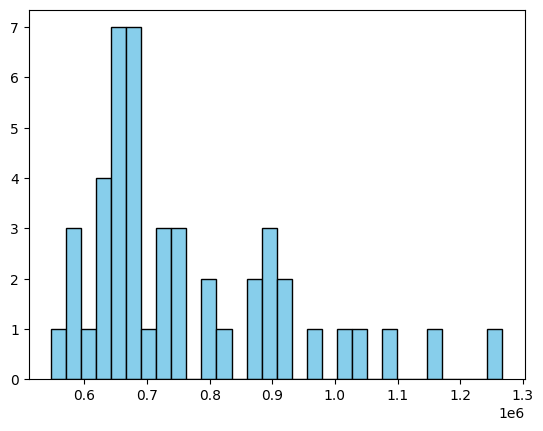

In [138]:
plt.hist(before['sales'], bins=30, color='skyblue', edgecolor='black');


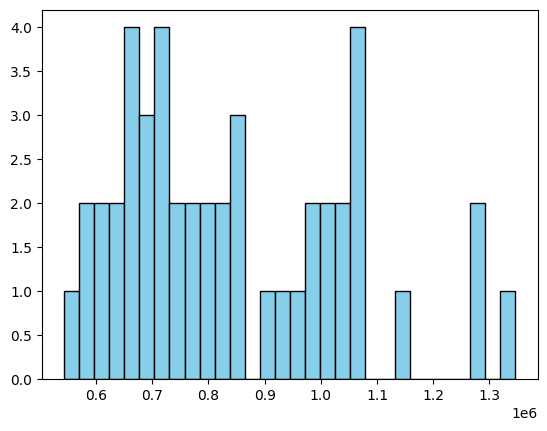

In [139]:
plt.hist(after['sales'], bins=30, color='skyblue', edgecolor='black');


In [140]:
stat, p_value = mannwhitneyu(before['sales'], after['sales'])

print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

U statistic: 785.0
P-value: 0.03334269022409122


In [141]:
before[['sales']].describe()

,sales
count,4.600000e+01
mean,7.631802e+05
std,1.625897e+05
min,5.467852e+05
25%,6.606319e+05
50%,6.925578e+05
75%,8.769561e+05
max,1.266908e+06


In [142]:
after[['sales']].describe()

,sales
count,4.600000e+01
mean,8.427815e+05
std,2.017883e+05
min,5.433398e+05
25%,6.832532e+05
50%,7.954300e+05
75%,9.943918e+05
max,1.345921e+06


In [143]:
df[['sales']].describe()

,sales
count,3.000888e+06
mean,3.577757e+02
std,1.101998e+03
min,0.000000e+00
25%,0.000000e+00
50%,1.100000e+01
75%,1.958473e+02
max,1.247170e+05


In [144]:
holiday_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [145]:
del avg_sales_by_month,avg_sales_by_weekday,avg_sales_year_family,moving_average,daily_df,daily_oil,daily_sales
del train_set,oil_set,transactions_set,stores_set,before,after,weekend_mask
del fig,fig1,fig2,fig3,working_days,

In [146]:
%who

ARIMA	 AutoLSTM	 AutoNHITS	 LGBMRegressor	 LSTM	 LabelEncoder	 MAE	 MQLoss	 NHITS	 
NeuralForecast	 RMSE	 TimeSeriesSplit	 corr	 df	 display	 early_stopping	 evaluate	 events	 
go	 holiday_set	 lgb	 lilliefors	 local	 log_evaluation	 logging	 mae	 mannwhitneyu	 
mean_squared_error	 mean_squared_log_error	 mse	 national	 np	 p_value	 pd	 plot_series	 plt	 
product	 px	 regional	 rmse	 seasonal_decompose	 shapiro	 sns	 spearmanr	 stat	 
stats	 train_test_split	 tune	 work_days_left	 


In [147]:
holiday_set['date'] = pd.to_datetime(holiday_set['date'])
holiday_set[holiday_set['transferred']==True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [148]:
#Το προβλημα με τα transfers
temp1 = holiday_set[(holiday_set['type']=='Holiday')& (holiday_set['transferred']==True)].drop('transferred',axis=1).reset_index(drop=True)
temp2 = holiday_set[(holiday_set['type']=='Transfer')].drop('transferred',axis=1).reset_index(drop=True)
temp = pd.concat([temp1,temp2],axis=1)
temp = temp.iloc[:,[5,1,2,3,4,]]
holiday_set = holiday_set[(holiday_set['type']!='Transfer')& (holiday_set['transferred']==False)].drop('transferred',axis=1)
holiday_set = pd.concat([holiday_set, temp]).reset_index(drop=True)
del temp,temp1,temp2

In [149]:
holiday_set['type']= np.where(holiday_set['type']=='Additional','Holiday',holiday_set['type'])
holiday_set['type']= np.where(holiday_set['type']=='Bridge','Holiday',holiday_set['type'])

In [150]:
work_days_left = holiday_set[holiday_set.type=='Work Day']
holiday_set = holiday_set[holiday_set.type!='Work Day']

In [151]:
events = holiday_set[holiday_set.type=='Event'].drop(['type','locale','locale_name'],axis=1)
events= events.rename({"description":"event"},axis=1)
holiday_set = holiday_set[holiday_set.type!='Event'].drop("type",axis=1)

In [152]:
regional = holiday_set[holiday_set['locale']=='Regional'].rename({"locale_name":"state","description":"holiday_regional"},axis=1).drop("locale",axis=1).drop_duplicates()
national = holiday_set[holiday_set['locale']=='National'].rename({"description":"holiday_national"},axis=1).drop(["locale","locale_name"],axis=1).drop_duplicates()
local = holiday_set[holiday_set['locale']=='Local'].rename({"locale_name":"city","description":"holiday_local"},axis=1).drop("locale",axis=1).drop_duplicates()

In [169]:
print(national['date'].duplicated().sum())
print(regional['date'].duplicated().sum())
print(local['date'].duplicated().sum())
print(events['date'].duplicated().sum())


0
0
0
0


In [170]:
df.shape

(3000888, 17)

In [165]:
national.head()

,date,holiday_national
14,2012-08-10,Primer Grito de Independencia
19,2012-11-02,Dia de Difuntos
20,2012-11-03,Independencia de Cuenca
29,2012-12-21,Navidad-4
31,2012-12-22,Navidad-3


In [168]:
national = national.drop_duplicates(subset=['date'])
regional = regional.drop_duplicates(subset=['date'])
local = local.drop_duplicates(subset=['date'])
events = events.drop_duplicates(subset=['date'])

In [171]:
local['date'] = pd.to_datetime(local['date'])
national['date'] = pd.to_datetime(national['date'])
regional['date'] = pd.to_datetime(regional['date'])

In [172]:
df = pd.merge(df,national,how='left',on='date')
df = pd.merge(df,regional,how='left',on=['date',"state"])
df = pd.merge(df,local,how='left',on=['date',"city"])
df = pd.merge(df,events,on=['date'],how='left')
del national,regional,local

In [ ]:
df.shape # AYTO Πρεπει να μπει ακριβως κατω απο τα merge

(3000888, 21)

In [ ]:
# Make sure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Generate complete date range from min to max
full_range = pd.date_range(start=df['date'].min(), end=df['date'].max())

# Get unique dates from your data
present_dates = df['date'].drop_duplicates()

# Find missing dates
missing_dates = full_range.difference(present_dates)

# Output missing dates
print("Missing dates:")
print(missing_dates)


Missing dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [ ]:
missing_df = pd.DataFrame({'date': missing_dates})
store_family_combos = df[['store_nbr', 'family', 'city', 'state', 'cluster','type']].drop_duplicates()
missing_df = pd.DataFrame([(d, *row) for d in missing_dates for row in store_family_combos.itertuples(index=False)],
                          columns=['date', 'store_nbr', 'family', 'city', 'state', 'cluster','type'])
missing_df['id'] = range(3000888, 3000888 + len(missing_df))
missing_df['sales'] = 0
missing_df['onpromotion'] = 0
missing_df['transactions'] = 0
missing_df['day'] = missing_df['date'].dt.day
missing_df['month'] = missing_df['date'].dt.month
missing_df['year'] = missing_df['date'].dt.year
missing_df['month_name'] = missing_df['date'].dt.month_name()
missing_df['day_nbr'] = missing_df['date'].dt.weekday
missing_df['holiday_national'] = 'no_holiday'
missing_df['holiday_regional'] = 'no_holiday'
missing_df['holiday_local'] = 'no_holiday'
missing_df['event'] = 'Christmas'

In [237]:
dates = ['2013-12-24', '2014-12-24', '2015-12-24', '2016-12-24']
df[df['date'].isin(pd.to_datetime(dates))].drop_duplicates(subset=['date'])


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,day,year,month,month_name,day_nbr,holiday_national,holiday_regional,holiday_local,event
636174,636174,2013-12-24,1,AUTOMOTIVE,1.0,0,Quito,Pichincha,D,13,98.87,2844.0,Tuesday,2013,12,December,1,Navidad-1,NaN,NaN,NaN
1284822,1284822,2014-12-24,1,AUTOMOTIVE,6.0,0,Quito,Pichincha,D,13,55.70,2800.0,Wednesday,2014,12,December,2,Navidad-1,NaN,NaN,NaN
1933470,1933470,2015-12-24,1,AUTOMOTIVE,4.0,0,Quito,Pichincha,D,13,37.62,2775.0,Thursday,2015,12,December,3,Navidad-1,NaN,NaN,NaN
2583900,2583900,2016-12-24,1,AUTOMOTIVE,6.0,0,Quito,Pichincha,D,13,52.01,1993.0,Saturday,2016,12,December,5,Navidad-1,NaN,NaN,NaN


In [ ]:
missing_df['dcoilwtico'] = missing_df['dcoilwtico'].astype(float)
missing_df.loc[missing_df['date'] == '2013-12-25', 'dcoilwtico'] = 98.87
missing_df.loc[missing_df['date'] == '2014-12-25', 'dcoilwtico'] = 55.70
missing_df.loc[missing_df['date'] == '2015-12-25', 'dcoilwtico'] = 37.62
missing_df.loc[missing_df['date'] == '2016-12-25', 'dcoilwtico'] = 52.01

In [244]:
missing_df.shape

(7128, 21)

In [ ]:
df_filled= pd.concat([df, missing_df]).reset_index(drop=True) # asto etsi na doume an tha doulepsei to arima 

In [242]:
df.shape

(3008016, 21)

In [222]:
df_filled['date'].nunique()


1688

In [211]:
df.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,day,year,month,month_name,day_nbr,holiday_national,holiday_regional,holiday_local,event
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0,Tuesday,2017,8,August,1,NaN,NaN,NaN,NaN
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0,Tuesday,2017,8,August,1,NaN,NaN,NaN,NaN
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0,Tuesday,2017,8,August,1,NaN,NaN,NaN,NaN
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,2155.0,Tuesday,2017,8,August,1,NaN,NaN,NaN,NaN
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6,47.57,2155.0,Tuesday,2017,8,August,1,NaN,NaN,NaN,NaN


In [82]:
df["holiday_national_binary"] = np.where(df["holiday_national"].notnull(),1,0)
df["holiday_regional_binary"] = np.where(df["holiday_regional"].notnull(),1,0)
df["holiday_local_binary"] = np.where(df["holiday_local"].notnull(),1,0)

In [83]:
#Target encoding
# df['event'] = df['event'].fillna('no_event')
# event_means = df.groupby('event')['sales'].mean()
# df['event_encoded'] = df['event'].map(event_means)

In [84]:
encoded_events= pd.get_dummies(events,"event",dtype=int)
encoded_events.columns=encoded_events.columns.str.replace(" ","_")
encoded_events.columns=encoded_events.columns.str.replace(":","_")
encoded_events.columns=encoded_events.columns.str.replace("+","_")
encoded_events.columns=encoded_events.columns.str.replace("-","_")
df = pd.merge(df,encoded_events,how='left',on='date')
del encoded_events,events

In [ ]:
df.shape